In [39]:
from scipy import*  
from numpy import*
def Eur_price(S0,E,T,N,r,sigma):
    
    dt=T/N
    U=exp(sigma*sqrt(dt))
    D=exp(-sigma*sqrt(dt))
    R=(exp(r*dt))
    q=(R-D)/(U-D)
    V_old=zeros(N+1)
    V_new=zeros(N+1)
    for m in range(0,N+1):
        V_old[m]=max(E-S0*U**m*D**(N-m),0)    
    for j in range(N-1,-1,-1):
        for m in range(0,j+1):
            V_new[m]=(q*V_old[m+1]+(1-q)*V_old[m])/R
        for m in range(0,j+1):
            V_old[m]=V_new[m]
    return(V_new[0])

## finding and printing European put option with parameters (Parameter of name = 99)
print('The European put option price (CRR) is %8.5f.' % Eur_price(S0=100,E=99,T=2,N=300,r=0.03,sigma=np.sqrt(0.15))) #N=300
print('The European put option price (CRR) is %8.5f.' % Eur_price(S0=100,E=99,T=2,N=400,r=0.03,sigma=np.sqrt(0.15))) #N=400
print('The European put option price (CRR) is %8.5f.' % Eur_price(S0=100,E=99,T=2,N=500,r=0.03,sigma=np.sqrt(0.15))) #N=500

The European put option price (CRR) is 17.63471.
The European put option price (CRR) is 17.63622.
The European put option price (CRR) is 17.63689.


In [40]:
from scipy import*
from numpy import*
def Amer_price(S0,E,T,N,r,sigma,cp):
    dt=T/N
    U=exp(sigma*sqrt(dt))
    D=exp(-sigma*sqrt(dt))
    R=(exp(r*dt))
    q=(R-D)/(U-D)
    V_old=zeros(N+1)
    V_new=zeros(N+1)
    for m in range(0,N+1):
        V_old[m]=max(cp*(S0*U**m*D**(N-m)-E),0)    
    for j in range(N-1,-1,-1):
        for m in range(0,j+1):
            V_new[m]=(q*V_old[m+1]+(1-q)*V_old[m])/R
            V_new[m]=max(V_new[m],max(cp*(S0*U**m*D**(j-m)-E),0))
        for m in range(0,j+1):
            V_old[m]=V_new[m]
    return(V_new[0])

## finding and printing American put option with parameters (Parameter of name = 99)
print('The American put option price (CRR) is %8.5f.' % Amer_price(S0=100,E=99,T=2,N=300,r=0.03,sigma=np.sqrt(0.15),cp=-1))
print('The American put option price (CRR) is %8.5f.' % Amer_price(S0=100,E=99,T=2,N=400,r=0.03,sigma=np.sqrt(0.15),cp=-1))
print('The American put option price (CRR) is %8.5f.' % Amer_price(S0=100,E=99,T=2,N=500,r=0.03,sigma=np.sqrt(0.15),cp=-1))

The American put option price (CRR) is 18.28093.
The American put option price (CRR) is 18.28181.
The American put option price (CRR) is 18.28213.


In [38]:
#Guided myself through the book: Mastering Python for Finance, therefore, this code is not my own. I used the book and made
#the enough adjustments to fit the purpose of the Homework

import numpy as np
import math
from scipy.stats import norm

#Defining an object, in this case, the option and it's attributes

class StockOption(object):
    
    #K=E for the parameters given by the professor

    def __init__(self, S0, K, r, T, N, params):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N) # Ensure N have at least 1 time step
        self.STs = None  # Declare the stock prices tree

        """ Optional parameterss used by derived classes """
        self.pu = params.get("pu", 0)  # Probability of up state
        self.pd = params.get("pd", 0)  # Probability of down state
        self.div = params.get("div", 0)  # Divident yield
        self.sigma = params.get("sigma", 0)  # Volatility
        self.is_call = params.get("is_call", True)  # Call or put
        self.is_european = params.get("is_eu", True)  # Eu or Am

        """ Computed values """
        self.dt = T/float(N)  # Single time step, in years
        self.df = math.exp(
            -(r-self.div) * self.dt)  # Discount factor

class BinomialTreeOption(StockOption): #Setting up the Binomial Tree that will be the foundation for \
    #the subsequent Binomial/Trinomial models

    def _setup_parameters_(self):
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt) -
                   self.d)/(self.u-self.d)
        self.qd = 1-self.qu

    def _initialize_stock_price_tree_(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches*self.u,
                                 [prev_branches[-1]*self.d]))
            self.STs.append(st)  # Add nodes at each time step

    def _initialize_payoffs_tree_(self):
        # The payoffs when option expires
        return np.maximum(
            0, (self.STs[self.N]-self.K) if self.is_call
            else (self.K-self.STs[self.N]))

    def __check_early_exercise__(self, payoffs, node):
        early_ex_payoff = \
            (self.STs[node] - self.K) if self.is_call \
            else (self.K - self.STs[node])

        return np.maximum(payoffs, early_ex_payoff)

    def _traverse_tree_(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1] * self.qu +
                       payoffs[1:] * self.qd) * self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.__check_early_exercise__(payoffs,
                                                        i)

        return payoffs

    def __begin_tree_traversal__(self):
        payoffs = self._initialize_payoffs_tree_()
        return self._traverse_tree_(payoffs)

    def price(self):
        self._setup_parameters_()
        self._initialize_stock_price_tree_()
        payoffs = self.__begin_tree_traversal__()

        return payoffs[0]

if __name__ == "__main__":
    
    
    am_option = BinomialTreeOption(
        50, 50, 0.05, 0.5, 2,
        {"pu": 0.2, "pd": 0.2, "is_call": False, "is_eu": False})
    # print(am_option.price()) #Testing
    
##############LEISEN-REIMER############
    
class BinomialLROption(BinomialTreeOption):
    def _setup_parameters_(self):
        odd_N = self.N if (self.N%2 == 1) else (self.N+1)
        d1 = (math.log(self.S0/self.K) + ((self.r-self.div) + (self.sigma**2)/2.) * self.T) / (self.sigma * math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) + ((self.r-self.div) - (self.sigma**2)/2.) * self.T) / (self.sigma * math.sqrt(self.T)) 
        pp_2_inversion = \
        lambda z, n: \
        .5 + math.copysign(1, z) * \
        math.sqrt(.25 - .25 * math.exp(
            -((z/(n+1./3.+.1/(n+1)))**2.)*(n+1./6.)))
        pbar = pp_2_inversion(d1, odd_N)
        self.p = pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df - self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p
        
#S = 100; K(E) = 99; r = 0.03, T = 2; N = 300, 400 or 500 sigma = 0.15 => Parameter by name

lreu_option300 = BinomialLROption(100, 99, 0.03, 2, 300, {"sigma": np.sqrt(0.15), "is_call": False})
lreu_option400 = BinomialLROption(100, 99, 0.03, 2, 400, {"sigma": np.sqrt(0.15), "is_call": False})
lreu_option500 = BinomialLROption(100, 99, 0.03, 2, 500, {"sigma": np.sqrt(0.15), "is_call": False})
lram_option300 = BinomialLROption(100, 99, 0.03, 2, 300, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})
lram_option400 = BinomialLROption(100, 99, 0.03, 2, 400, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})
lram_option500 = BinomialLROption(100, 99, 0.03, 2, 500, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})

#Print the output of the results
print('The price of the European put option is equal to %8.5f.' % (lreu_option300.price()) + '=> N=300; Leisen-Reimer')
print('The price of the European put option is equal to %8.5f.' % (lreu_option400.price()) + '=> N=400; Leisen-Reimer')
print('The price of the European put option is equal to %8.5f.' % (lreu_option500.price()) + '=> N=500; Leisen-Reimer')
print('The price of the American put option is equal to %8.5f.' % (lram_option300.price()) + '=> N=300; Leisen-Reimer')
print('The price of the American put option is equal to %8.5f.' % (lram_option400.price()) + '=> N=400; Leisen-Reimer')
print('The price of the American put option is equal to %8.5f.' % (lram_option500.price()) + '=> N=500; Leisen-Reimer')

##########TRINOMIAL############

class TrinomialTreeOption(BinomialTreeOption):

    def _setup_parameters_(self):
        """ Required calculations for the model """
        self.u = math.exp(self.sigma*math.sqrt(2.*self.dt))
        self.d = 1/self.u
        self.m = 1
        self.qu = ((math.exp((self.r-self.div) *
                             self.dt/2.) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2
        self.qd = ((math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp((self.r-self.div) *
                             self.dt/2.)) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2.

        self.qm = 1 - self.qu - self.qd

    def _initialize_stock_price_tree_(self):
        """ Initialize a 2D tree at t=0 """
        self.STs = [np.array([self.S0])]

        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate(
                (prev_nodes*self.u, [prev_nodes[-1]*self.m,
                                     prev_nodes[-1]*self.d]))
            self.STs.append(self.ST)

    def _traverse_tree_(self, payoffs):
        """ Traverse the tree backwards """
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu +
                       payoffs[1:-1] * self.qm +
                       payoffs[2:] * self.qd) * self.df

            if not self.is_european:
                payoffs = self.__check_early_exercise__(payoffs,
                                                        i)

        return payoffs

if __name__ == "__main__":
    
#S = 100; K(E) = 99; r = 0.03, T = 2; N = 300, 400 or 500 sigma = 0.15 => Parameter by name

    trinomial_eu300 = TrinomialTreeOption(100, 99, 0.03, 2, 300, {"sigma": np.sqrt(0.15), "is_call": False})
    trinomial_eu400 = TrinomialTreeOption(100, 99, 0.03, 2, 400, {"sigma": np.sqrt(0.15), "is_call": False})
    trinomial_eu500 = TrinomialTreeOption(100, 99, 0.03, 2, 500, {"sigma": np.sqrt(0.15), "is_call": False})
    trinomial_am300 = TrinomialTreeOption(100, 99, 0.03, 2, 300, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})
    trinomial_am400 = TrinomialTreeOption(100, 99, 0.03, 2, 400, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})
    trinomial_am500 = TrinomialTreeOption(100, 99, 0.03, 2, 500, {"sigma": np.sqrt(0.15), "is_call": False, "is_eu": False})
    
print('The price of the European put option is equal to %8.5f.' % (trinomial_eu300.price()) + '=> N=300; Trinomial')
print('The price of the European put option is equal to %8.5f.' % (trinomial_eu400.price()) + '=> N=400; Trinomial')
print('The price of the European put option is equal to %8.5f.' % (trinomial_eu500.price()) + '=> N=500; Trinomial')

print('The price of the American put option is equal to %8.5f.' % (trinomial_am300.price()) + '=> N=300; Trinomial')
print('The price of the American put option is equal to %8.5f.' % (trinomial_am400.price()) + '=> N=400; Trinomial')
print('The price of the American put option is equal to %8.5f.' % (trinomial_am500.price()) + '=> N=500; Trinomial')


#############BLACK-SCHOLES##############

#K=E; Parameter = 99

S = 100

K = 99

T = 2

r = 0.03

sigma = 0.15

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)


bs_put_result = bs_put(100,99,2,0.03,np.sqrt(0.15))

print('The European Put Option Price is: %8.5f.' % bs_put_result, ' => Black-Scholes')

The price of the European put option is equal to 17.56796.=> N=300; Leisen-Reimer
The price of the European put option is equal to 17.58441.=> N=400; Leisen-Reimer
The price of the European put option is equal to 17.59431.=> N=500; Leisen-Reimer
The price of the American put option is equal to 18.21908.=> N=300; Leisen-Reimer
The price of the American put option is equal to 18.23395.=> N=400; Leisen-Reimer
The price of the American put option is equal to 18.24288.=> N=500; Leisen-Reimer
The price of the European put option is equal to 17.63719.=> N=300; Trinomial
The price of the European put option is equal to 17.63736.=> N=400; Trinomial
The price of the European put option is equal to 17.63728.=> N=500; Trinomial
The price of the American put option is equal to 18.28048.=> N=300; Trinomial
The price of the American put option is equal to 18.28080.=> N=400; Trinomial
The price of the American put option is equal to 18.28085.=> N=500; Trinomial
The European Put Option Price is: 17.634

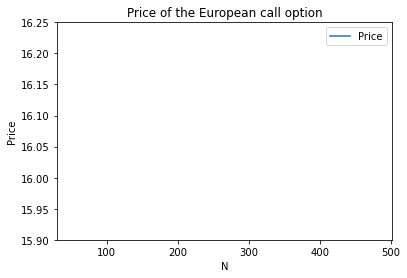

In [43]:
#Although I try to plot the chart like in the example on moodle, it doesn't work. Therefore I gave up on this.

import matplotlib.pyplot as plt
from numpy import*

V=zeros(501)
##initializing vector V with zeros to store option prices
for k in range(30,501):
    V[k]=Eur_price(100,99,2,k,0.03,sqrt(0.15))
    ## computing the prices
n = linspace(0, 500, 501)

plt.plot(V,n)

## definining the plot, the x-values are in vector n, y-values are in vector V.
plt.xlim((30, 501))
## limits of x-axis
plt.ylim((15.9,16.25))
## limits of y-axis (limits of option prices)
plt.ylabel('Price')
plt.xlabel('N')
plt.legend(['Price'], loc='best')
plt.title('Price of the European call option')
plt.show()
## show plot

 11.9830


NameError: name 'BinomialTreeOption' is not defined

The price of the European put option is equal to  5.19286.=> N=300; Leisen-Reimer
The price of the European put option is equal to  5.19899.=> N=400; Leisen-Reimer
The price of the European put option is equal to  5.20269.=> N=500; Leisen-Reimer
The price of the American put option is equal to 13.63828.=> N=300; Leisen-Reimer
The price of the American put option is equal to 13.64972.=> N=400; Leisen-Reimer
The price of the American put option is equal to 13.65662.=> N=500; Leisen-Reimer
The price of the European put option is equal to  5.22052.=> N=300; Trinomial
The price of the European put option is equal to  5.21939.=> N=400; Trinomial
The price of the European put option is equal to  5.21855.=> N=500; Trinomial
The price of the American put option is equal to  5.79207.=> N=300; Trinomial
The price of the American put option is equal to  5.79161.=> N=400; Trinomial
The price of the American put option is equal to  5.79121.=> N=500; Trinomial
The European Put Option Price is:  5.217